In [0]:
from PIL import Image
import imageio
import math
import numbers
import random
import numpy as np
import torchvision.transforms.functional as tf
from skimage.transform import resize as re
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
import numpy as np
import scipy.misc as m

# Helper libraries
import matplotlib
matplotlib.use('Agg')
from io import BytesIO



from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

from torch.utils import data
import caffe_pb2

from torch.autograd import Variable
from utils import conv2DBatchNormRelu, residualBlockPSP, pyramidPooling

In [0]:
def multi_scale_cross_entropy2d(input, target, weight=None, size_average=True, scale_weight=None):
    if not isinstance(input, tuple):
        return cross_entropy2d(input=input, target=target, weight=weight, size_average=size_average)

    # Auxiliary training for PSPNet [1.0, 0.4] and ICNet [1.0, 0.4, 0.16]
    if scale_weight is None:  # scale_weight: torch tensor type
        n_inp = len(input)
        scale = 0.4
        scale_weight = torch.pow(scale * torch.ones(n_inp), torch.arange(n_inp).float()).to(
            target.device
        )

    loss = 0.0
    for i, inp in enumerate(input):
        loss = loss + scale_weight[i] * cross_entropy2d(
            input=inp, target=target, weight=weight, size_average=size_average
        )

    return loss

In [0]:
import os
import torch
import numpy as np
import scipy.misc as m
from torch.utils import data


class cityscapeDatasetLoad(data.Dataset):
    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]
    label_colours = dict(zip(range(19), colors))
    mean_rgb = [0.0, 0.0, 0.0]

    def __init__(self, root, is_transform= True, img_size = (2048,1024), img_norm = True, version = "cityscapes"):
        self.root = root
        self.is_transform = is_transform
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array(self.mean_rgb)
        self.files = {}
        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [
            7,
            8,
            11,
            12,
            13,
            17,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            31,
            32,
            33,
        ]
        self.class_names = [
           
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]

    def __getitem__(self, index):
        img = imageio.imread(img_path)
        img = np.array(img, dtype = np.uint8)

        if self.is_transform:
            img = self.transform(img)
        return img

    def transform(self, img):
        img = np.array

        img = np.array(Image.fromarray(img).resize((self.img_size[0], self.img_size[1]), resample = 0))
                #img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).float()

        return img

    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb


In [0]:
pspnet_specs = {"cityscapes": {"n_classes": 19, "input_size": (713, 713), "block_config": [3, 4, 23, 3]}}


class pspnet(nn.Module):


    def __init__(
        self, n_classes=19, block_config=[3, 4, 23, 3], input_size=(473, 473), version=None
    ):

        super(pspnet, self).__init__()

        self.block_config = (
            pspnet_specs[version]["block_config"] if version is not None else block_config
        )
        self.n_classes = pspnet_specs[version]["n_classes"] if version is not None else n_classes
        self.input_size = pspnet_specs[version]["input_size"] if version is not None else input_size

        # Encoder
        self.convbnrelu1_1 = conv2DBatchNormRelu(
            in_channels=3, k_size=3, n_filters=64, padding=1, stride=2, bias=False
        )
        self.convbnrelu1_2 = conv2DBatchNormRelu(
            in_channels=64, k_size=3, n_filters=64, padding=1, stride=1, bias=False
        )
        self.convbnrelu1_3 = conv2DBatchNormRelu(
            in_channels=64, k_size=3, n_filters=128, padding=1, stride=1, bias=False
        )

        # Vanilla Residual Blocks
        self.res_block2 = residualBlockPSP(self.block_config[0], 128, 64, 256, 1, 1)
        self.res_block3 = residualBlockPSP(self.block_config[1], 256, 128, 512, 2, 1)

        # Dilated Residual Blocks
        self.res_block4 = residualBlockPSP(self.block_config[2], 512, 256, 1024, 1, 2)
        self.res_block5 = residualBlockPSP(self.block_config[3], 1024, 512, 2048, 1, 4)

        # Pyramid Pooling Module
        self.pyramid_pooling = pyramidPooling(2048, [6, 3, 2, 1])

        # Final conv layers
        self.cbr_final = conv2DBatchNormRelu(4096, 512, 3, 1, 1, False)
        self.dropout = nn.Dropout2d(p=0.1, inplace=False)
        self.classification = nn.Conv2d(512, self.n_classes, 1, 1, 0)

        # Auxiliary layers for training
        self.convbnrelu4_aux = conv2DBatchNormRelu(
            in_channels=1024, k_size=3, n_filters=256, padding=1, stride=1, bias=False
        )
        self.aux_cls = nn.Conv2d(256, self.n_classes, 1, 1, 0)

        # Define auxiliary loss function
        self.loss = multi_scale_cross_entropy2d

    def forward(self, x):
        inp_shape = x.shape[2:]

        # H, W -> H/2, W/2
        x = self.convbnrelu1_1(x)
        x = self.convbnrelu1_2(x)
        x = self.convbnrelu1_3(x)

        # H/2, W/2 -> H/4, W/4
        x = F.max_pool2d(x, 3, 2, 1)

        # H/4, W/4 -> H/8, W/8
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)

        # Auxiliary layers for training
        if self.training:
            x_aux = self.convbnrelu4_aux(x)
            x_aux = self.dropout(x_aux)
            x_aux = self.aux_cls(x_aux)

        x = self.res_block5(x)

        x = self.pyramid_pooling(x)

        x = self.cbr_final(x)
        x = self.dropout(x)

        x = self.classification(x)
        x = F.interpolate(x, size=inp_shape, mode="bilinear", align_corners=True)

        if self.training:
            return (x, x_aux)
        else:  # eval mode
            return x
    def load_pretrained_model(self, model_path):
        """
        Load weights from caffemodel w/o caffe dependency
        and plug them in corresponding modules
        """
        # My eyes and my heart both hurt when writing this method

        # Only care about layer_types that have trainable parameters
        ltypes = ["BNData", "ConvolutionData", "HoleConvolutionData"]

        def _get_layer_params(layer, ltype):

            if ltype == "BNData":
                gamma = np.array(layer.blobs[0].data)
                beta = np.array(layer.blobs[1].data)
                mean = np.array(layer.blobs[2].data)
                var = np.array(layer.blobs[3].data)
                return [mean, var, gamma, beta]

            elif ltype in ["ConvolutionData", "HoleConvolutionData"]:
                is_bias = layer.convolution_param.bias_term
                weights = np.array(layer.blobs[0].data)
                bias = []
                if is_bias:
                    bias = np.array(layer.blobs[1].data)
                return [weights, bias]

            elif ltype == "InnerProduct":
                raise Exception("Fully connected layers {}, not supported".format(ltype))

            else:
                raise Exception("Unkown layer type {}".format(ltype))

        net = caffe_pb2.NetParameter()
        with open(model_path, "rb") as model_file:
            net.MergeFromString(model_file.read())

        # dict formatted as ->  key:<layer_name> :: value:<layer_type>
        layer_types = {}
        # dict formatted as ->  key:<layer_name> :: value:[<list_of_params>]
        layer_params = {}

        for l in net.layer:
            lname = l.name
            ltype = l.type
            if ltype in ltypes:
                print("Processing layer {}".format(lname))
                layer_types[lname] = ltype
                layer_params[lname] = _get_layer_params(l, ltype)

        # Set affine=False for all batchnorm modules
        def _no_affine_bn(module=None):
            if isinstance(module, nn.BatchNorm2d):
                module.affine = False

            if len([m for m in module.children()]) > 0:
                for child in module.children():
                    _no_affine_bn(child)

        # _no_affine_bn(self)

        def _transfer_conv(layer_name, module):
            weights, bias = layer_params[layer_name]
            w_shape = np.array(module.weight.size())

            print(
                "CONV {}: Original {} and trans weights {}".format(
                    layer_name, w_shape, weights.shape
                )
            )

            module.weight.data.copy_(torch.from_numpy(weights).view_as(module.weight))

            if len(bias) != 0:
                b_shape = np.array(module.bias.size())
                print(
                    "CONV {}: Original {} and trans bias {}".format(layer_name, b_shape, bias.shape)
                )
                module.bias.data.copy_(torch.from_numpy(bias).view_as(module.bias))

        def _transfer_conv_bn(conv_layer_name, mother_module):
            conv_module = mother_module[0]
            bn_module = mother_module[1]

            _transfer_conv(conv_layer_name, conv_module)

            mean, var, gamma, beta = layer_params[conv_layer_name + "/bn"]
            print(
                "BN {}: Original {} and trans weights {}".format(
                    conv_layer_name, bn_module.running_mean.size(), mean.shape
                )
            )
            bn_module.running_mean.copy_(torch.from_numpy(mean).view_as(bn_module.running_mean))
            bn_module.running_var.copy_(torch.from_numpy(var).view_as(bn_module.running_var))
            bn_module.weight.data.copy_(torch.from_numpy(gamma).view_as(bn_module.weight))
            bn_module.bias.data.copy_(torch.from_numpy(beta).view_as(bn_module.bias))

        def _transfer_residual(prefix, block):
            block_module, n_layers = block[0], block[1]

            bottleneck = block_module.layers[0]
            bottleneck_conv_bn_dic = {
                prefix + "_1_1x1_reduce": bottleneck.cbr1.cbr_unit,
                prefix + "_1_3x3": bottleneck.cbr2.cbr_unit,
                prefix + "_1_1x1_proj": bottleneck.cb4.cb_unit,
                prefix + "_1_1x1_increase": bottleneck.cb3.cb_unit,
            }

            for k, v in bottleneck_conv_bn_dic.items():
                _transfer_conv_bn(k, v)

            for layer_idx in range(2, n_layers + 1):
                residual_layer = block_module.layers[layer_idx - 1]
                residual_conv_bn_dic = {
                    "_".join(
                        map(str, [prefix, layer_idx, "1x1_reduce"])
                    ): residual_layer.cbr1.cbr_unit,
                    "_".join(map(str, [prefix, layer_idx, "3x3"])): residual_layer.cbr2.cbr_unit,
                    "_".join(
                        map(str, [prefix, layer_idx, "1x1_increase"])
                    ): residual_layer.cb3.cb_unit,
                }

                for k, v in residual_conv_bn_dic.items():
                    _transfer_conv_bn(k, v)

        convbn_layer_mapping = {
            "conv1_1_3x3_s2": self.convbnrelu1_1.cbr_unit,
            "conv1_2_3x3": self.convbnrelu1_2.cbr_unit,
            "conv1_3_3x3": self.convbnrelu1_3.cbr_unit,
            "conv5_3_pool6_conv": self.pyramid_pooling.paths[0].cbr_unit,
            "conv5_3_pool3_conv": self.pyramid_pooling.paths[1].cbr_unit,
            "conv5_3_pool2_conv": self.pyramid_pooling.paths[2].cbr_unit,
            "conv5_3_pool1_conv": self.pyramid_pooling.paths[3].cbr_unit,
            "conv5_4": self.cbr_final.cbr_unit,
            "conv4_" + str(self.block_config[2] + 1): self.convbnrelu4_aux.cbr_unit,
        }  # Auxiliary layers for training

        residual_layers = {
            "conv2": [self.res_block2, self.block_config[0]],
            "conv3": [self.res_block3, self.block_config[1]],
            "conv4": [self.res_block4, self.block_config[2]],
            "conv5": [self.res_block5, self.block_config[3]],
        }

        # Transfer weights for all non-residual conv+bn layers
        for k, v in convbn_layer_mapping.items():
            _transfer_conv_bn(k, v)

        # Transfer weights for final non-bn conv layer
        _transfer_conv("conv6", self.classification)
        _transfer_conv("conv6_1", self.aux_cls)

        # Transfer weights for all residual layers
        for k, v in residual_layers.items():
            _transfer_residual(k, v)
    
    def tile_predict(self, imgs, include_flip_mode=True):
        """
        Predict by takin overlapping tiles from the image.
        Strides are adaptively computed from the imgs shape
        and input size
        :param imgs: torch.Tensor with shape [N, C, H, W] in BGR format
        :param side: int with side length of model input
        :param n_classes: int with number of classes in seg output.
        """

        side_x, side_y = self.input_size
        n_classes = self.n_classes
        n_samples, c, h, w = imgs.shape
        # n = int(max(h,w) / float(side) + 1)
        n_x = int(h / float(side_x) + 1)
        n_y = int(w / float(side_y) + 1)
        stride_x = (h - side_x) / float(n_x)
        stride_y = (w - side_y) / float(n_y)

        x_ends = [[int(i * stride_x), int(i * stride_x) + side_x] for i in range(n_x + 1)]
        y_ends = [[int(i * stride_y), int(i * stride_y) + side_y] for i in range(n_y + 1)]

        pred = np.zeros([n_samples, n_classes, h, w])
        count = np.zeros([h, w])

        slice_count = 0
        for sx, ex in x_ends:
            for sy, ey in y_ends:
                slice_count += 1

                imgs_slice = imgs[:, :, sx:ex, sy:ey]
                if include_flip_mode:
                    imgs_slice_flip = torch.from_numpy(
                        np.copy(imgs_slice.cpu().numpy()[:, :, :, ::-1])
                    ).float()

                is_model_on_cuda = next(self.parameters()).is_cuda

                inp = Variable(imgs_slice, volatile=True)
                if include_flip_mode:
                    flp = Variable(imgs_slice_flip, volatile=True)

                if is_model_on_cuda:
                    inp = inp.cuda()
                    if include_flip_mode:
                        flp = flp.cuda()

                psub1 = F.softmax(self.forward(inp), dim=1).data.cpu().numpy()
                if include_flip_mode:
                    psub2 = F.softmax(self.forward(flp), dim=1).data.cpu().numpy()
                    psub = (psub1 + psub2[:, :, :, ::-1]) / 2.0
                else:
                    psub = psub1

                pred[:, :, sx:ex, sy:ey] = psub
                count[sx:ex, sy:ey] += 1.0

        score = (pred / count[None, None, ...]).astype(np.float32)
        return score / np.expand_dims(score.sum(axis=1), axis=1)

    


   

In [0]:
vid = '/content/drive/My Drive/cityscapes/videos/mit_driveseg_sample.mp4'

In [0]:
import cv2

def count_frames(path, override=False):
	# grab a pointer to the video file and initialize the total
	# number of frames read
	video = cv2.VideoCapture(path)
	total = 0
	# if the override flag is passed in, revert to the manual
	# method of counting frames
	if override:
		total = count_frames_manual(video)
  # otherwise, let's try the fast way first
	else:
		# lets try to determine the number of frames in a video
		# via video properties; this method can be very buggy
		# and might throw an error based on your OpenCV version
		# or may fail entirely based on your which video codecs
		# you have installed
		try:
			# check if we are using OpenCV 3
			if is_cv3():
				total = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
			# otherwise, we are using OpenCV 2.4
			else:
				total = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
		# uh-oh, we got an error -- revert to counting manually
		except:
			total = count_frames_manual(video)
	# release the video file pointer
	video.release()
	# return the total number of frames in the video
	return total


def count_frames_manual(video):
	# initialize the total number of frames read
	total = 0
	# loop over the frames of the video
	while True:
		# grab the current frame
		(grabbed, frame) = video.read()
	 
		# check to see if we have reached the end of the
		# video
		if not grabbed:
			break
		# increment the total number of frames read
		total += 1
	# return the total number of frames in the video file
	return total


In [0]:
num_frames = count_frames(vid)


In [19]:
print(num_frames)

598


In [20]:
model = pspnet(version = "cityscapes")
caffemodel_dir_path = "/content/drive/My Drive/cityscapes/model/PSP/"
      
model.load_pretrained_model(
          model_path=os.path.join(caffemodel_dir_path, "pspnet101_cityscapes.caffemodel")
      )

Processing layer conv1_1_3x3_s2
Processing layer conv1_1_3x3_s2/bn
Processing layer conv1_2_3x3
Processing layer conv1_2_3x3/bn
Processing layer conv1_3_3x3
Processing layer conv1_3_3x3/bn
Processing layer conv2_1_1x1_reduce
Processing layer conv2_1_1x1_reduce/bn
Processing layer conv2_1_3x3
Processing layer conv2_1_3x3/bn
Processing layer conv2_1_1x1_increase
Processing layer conv2_1_1x1_increase/bn
Processing layer conv2_1_1x1_proj
Processing layer conv2_1_1x1_proj/bn
Processing layer conv2_2_1x1_reduce
Processing layer conv2_2_1x1_reduce/bn
Processing layer conv2_2_3x3
Processing layer conv2_2_3x3/bn
Processing layer conv2_2_1x1_increase
Processing layer conv2_2_1x1_increase/bn
Processing layer conv2_3_1x1_reduce
Processing layer conv2_3_1x1_reduce/bn
Processing layer conv2_3_3x3
Processing layer conv2_3_3x3/bn
Processing layer conv2_3_1x1_increase
Processing layer conv2_3_1x1_increase/bn
Processing layer conv3_1_1x1_reduce
Processing layer conv3_1_1x1_reduce/bn
Processing layer con

In [0]:
def vis_segmentation_stream(image, seg_map, index):
    
    
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    #seg_image = label_to_color_image(seg_map).astype(np.uint8)
    seg_image = seg_map
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame#%d'%index)
    plt.grid('off')
    plt.tight_layout()
    plt.savefig("/content/drive/My Drive/cityscapes/model/PSP/RESULTS/frames_new/" + 'frame%d'%index)
    #cv2.imwrite(file_name , plt)
    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpg')    
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


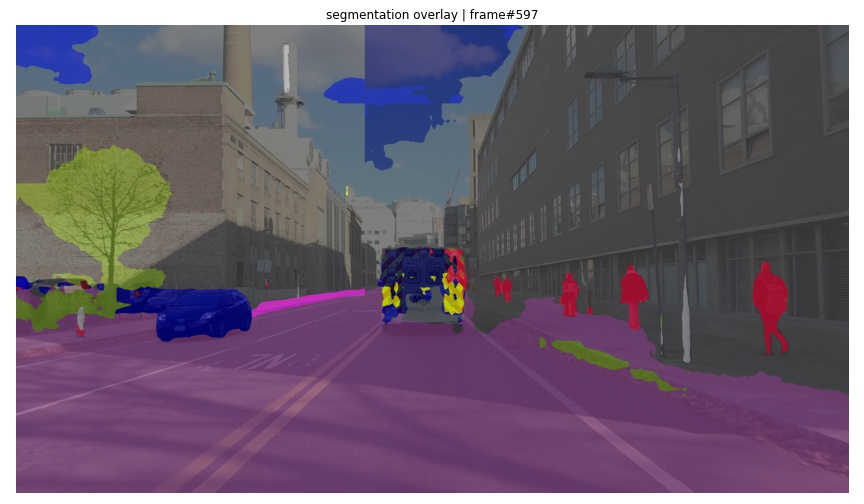

In [22]:
#VIDEO_SAVE_DIR = "/content/drive/My Drive/cityscapes/model/PSP/VIDEO_RESULTS/"
video = cv2.VideoCapture(vid)
dataset_root_dir = "/content/drive/My Drive/cityscapes/"
loader = cityscapeDatasetLoad(root = dataset_root_dir)
dst = loader
model.float()
model.cuda()
with torch.no_grad():
  model.eval()
try:
    for i in range(num_frames):
        _, frame = video.read()
        
        if not _: break
        original_img = Image.fromarray(frame[..., ::-1])
        #img = img.convert('RGB')
        #img = imageio.imread(frame[..., ::-1])     
        #img = imageio.imread(img_path)              
        img = frame.transpose(2,0,1)
        img = img.astype(np.float64)
        img -=np.array([123.68, 116.779, 103.939])[:, None, None]
        img = np.copy(img[::-1,:,:])
        img = torch.from_numpy(img).float()    #convert to torch tensor
        img = img.unsqueeze(0)
        out = model.tile_predict(img)
        pred = np.argmax(out, axis =1)[0]
        decoded = dst.decode_segmap(pred)
        vis_segmentation_stream(original_img, decoded, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")
